In [1]:
import numpy as np
import fnmatch
import xarray as xr
import os
from collections import defaultdict
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
from xmip.postprocessing import combine_datasets,_concat_sorted_time
from sklearn.decomposition import PCA
import gcsfs
fs = gcsfs.GCSFileSystem() # equivalent to fsspec.fs('gs')

/tmp/ipykernel_1330/2781798931.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


Loop over timeseries of `psl` & `sfcWind` at common 1.5 by 1.5 degree grid and open them:

In [2]:
#in_dir = '/home/jovyan/CMIP6cf/output/subsetted_forcing/'
var1 = 'psl'
var2 = 'sfcWind'

var1_dir = 'leap-persistent/timh37/CMIP6/timeseries/'+var1+'_europe'
var2_dir = 'leap-persistent/timh37/CMIP6/timeseries/'+var2+'_europe'

var1_models = [k.split('/')[-1] for k in fs.ls(var1_dir) if k.startswith('.')==False]
var2_models = [k.split('/')[-1] for k in fs.ls(var2_dir) if k.startswith('.')==False]

models = [k for k in var1_models if k in var2_models]
ddict = defaultdict(dict)

for source_id in ['ACCESS-CM2']:#models:
    var1_model_path = os.path.join(var1_dir,source_id)
    var2_model_path = os.path.join(var2_dir,source_id)
    
    var1_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var1_model_path) if s.startswith('.')==False] 
    var2_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var2_model_path) if s.startswith('.')==False]
    experiment_ids = list(set(var1_exps) & set(var2_exps))
    
    for experiment_id in set(experiment_ids): #for each experiment_id, open the datasets, concatenating all realizations:
        #load data:
        fn = fnmatch.filter(fs.ls(var1_model_path),'*'+experiment_id+'*')[0]
        fn = fn.split('/')[-1]
        
        var1_var2_data = xr.open_mfdataset((os.path.join('gs://',var1_model_path,fn),os.path.join('gs://',var2_model_path,fn)),engine='zarr',chunks={'member_id':1,'time':100000,'longitude':5})
        
        ddict[fn.replace('.zarr','')] = var1_var2_data

In [4]:
ds= ddict['ACCESS-CM2_gn_day_ssp245'].isel(member_id=0)

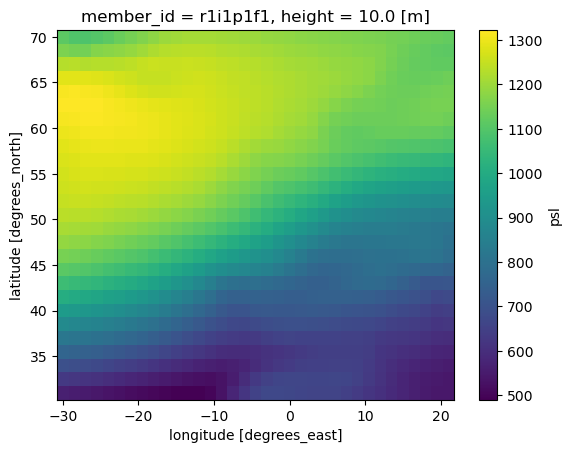

In [9]:
ds.std(dim='time').psl.plot()

In [36]:
a=ds.sel(time=slice('1850','2100')).std(dim='time')
b=ds.sel(time=slice('1980','2100')).std(dim='time')

In [37]:
np.abs(((a-b)/a)).sfcWind.max().values

array(0.04270566, dtype=float32)

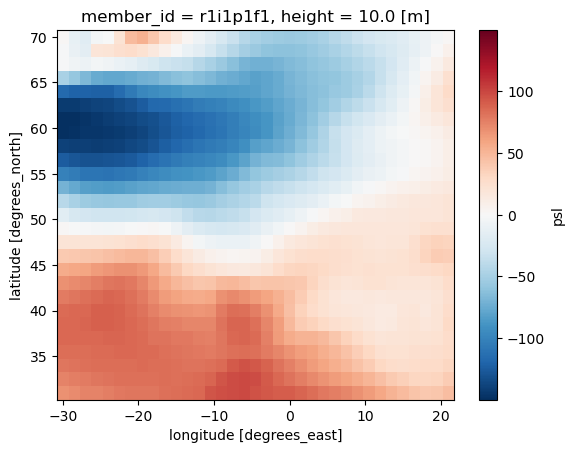

In [30]:
(a-b).psl.plot()

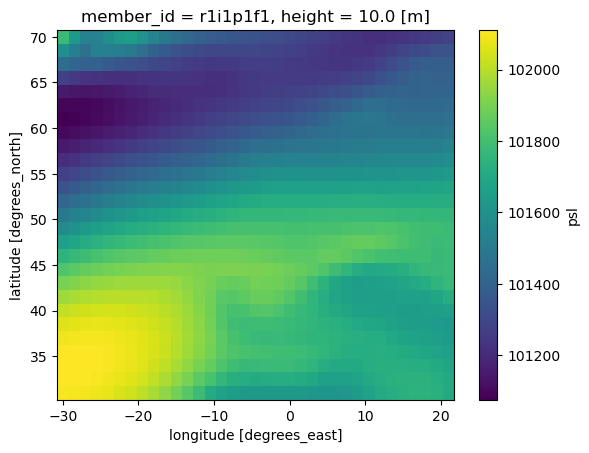

In [29]:
b.psl.plot()

Generate predictor data and multiply with regression coefficients:

In [4]:
predictors = (predictors-predictors.mean(dim='time'))/predictors.std(dim='time',ddof=0) #normalize predictor variables (ignores nan by default?)
       

  0%|          | 0/48 [00:00<?, ?it/s]